## Подготовка

In [20]:
!! pip install wordcloud
!! pip install xgboost

['Requirement already satisfied: xgboost in /opt/conda/lib/python3.9/site-packages (1.5.1)',
 'Requirement already satisfied: numpy in /opt/conda/lib/python3.9/site-packages (from xgboost) (1.21.1)',
 'Requirement already satisfied: scipy in /opt/conda/lib/python3.9/site-packages (from xgboost) (1.8.0)']

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import GridSearchCV
import re
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as stopwords_nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    display(df.head())
    print(df.info())
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    display(df.head())
    print(df.info())
else:
    print('Something is wrong') 

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Посмотрим визуально какие слова используются чаще всего 

(-0.5, 399.5, 199.5, -0.5)

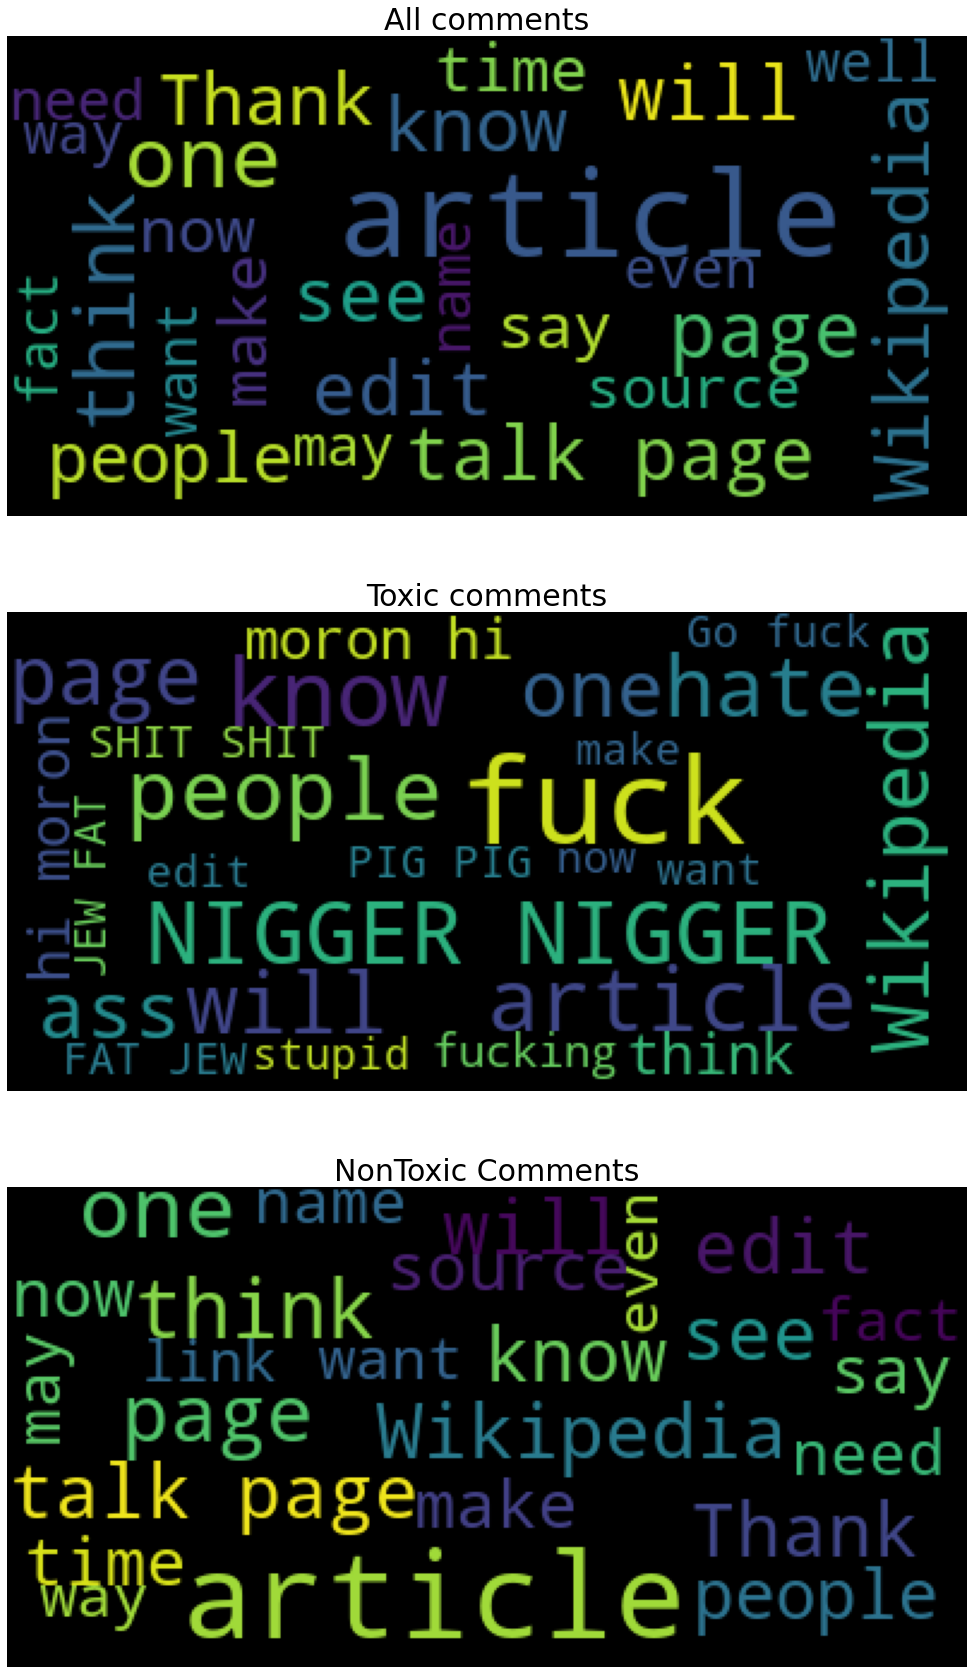

In [23]:
df_toxic = df[df['toxic']==1]
df_nottoxic = df[df['toxic']==0]

All = " ".join(review for review in df.text)
toxic = " ".join(review for review in df_toxic.text)
nottoxic = " ".join(review for review in df_nottoxic.text)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
wordcloud_all = WordCloud(max_font_size=50, max_words=25, background_color="black").generate(All)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=25, background_color="black").generate(toxic)
wordcloud_nottoxic = WordCloud(max_font_size=50, max_words=25, background_color="black").generate(nottoxic)


ax[0].imshow(wordcloud_all)
ax[0].set_title('All comments', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic)
ax[1].set_title('Toxic comments',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_nottoxic)
ax[2].set_title('NonToxic Comments',fontsize=30)
ax[2].axis('off')

In [24]:
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [25]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [26]:
corpus = df['text'].values

In [27]:
corpus_lemm = [lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]

In [28]:
stopwords = set(stopwords_nltk.words('english'))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(corpus_lemm, df['toxic'], 
                                                    test_size=0.2,
                                                    random_state=42)

In [30]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

In [31]:
count_tf_idf.fit(X_train)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [32]:
X_train = count_tf_idf.transform(X_train)

In [33]:
X_test = count_tf_idf.transform(X_test)

## Обучение

### Логистическая регрессия

In [ ]:
%%time
log_reg = LogisticRegression()
param = {'max_iter': [300, 500, 1000], 'C': [3, 5, 7]}
grid = GridSearchCV(log_reg, param_grid = param, scoring='f1', cv=5)
grid.fit(X_train, y_train)
f1=(grid.best_score_)
print('f1 модели:{:.4f}'.format(f1))
print('Лучшие гиперпараметры: ', grid.best_params_)

### Градиентный спуск

In [ ]:
%%time
xgb_clf = XGBClassifier(random_state=777, n_jobs=-1)
xgb_clf_params = {'n_estimators': [100, 500]}
xgb_clf_grid = GridSearchCV(xgb_clf, xgb_clf_params, scoring='f1')
xgb_clf_grid.fit(X_train, y_train)
f1=(xgb_clf_grid.best_score_)
print('f1 модели:{:.4f}'.format(f1))
print('Лучшие гиперпараметры: ', xgb_clf_grid.best_params_)

### Предсказание на тестовой выборке

In [ ]:
log_reg = LogisticRegression(max_iter=300, C = 7, random_state = 777)
log_reg.fit(X_train, y_train)
prediction = log_reg.predict(X_test)
f1_score(prediction, y_test)

## Выводы

В данной работе чуть лучшие результаты дала логистическая регрессия. Можно сказать, что на грани погрешности. По времени она тоже оказалась лучше. Этот проект в очередной раз иллюстрирует, что порой самые простые модели работают эффективнее и быстрее, чем модели сложные.